In [15]:
import string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from gensim.models.doc2vec import TaggedDocument
import nltk
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_auc_score
%matplotlib inline
pal = sns.color_palette()

In [10]:
df_train = pd.read_pickle("train_pp.pkl")
df_test = pd.read_pickle("test_pp.pkl")

In [11]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc
145367,145367,229850,229851,Is there only one consciousness?,Is consciousness one for everyone?,1,"[is, there, only, one, consciousness, ?]","[is, consciousness, one, for, everyone, ?]",?,?,True
123169,123169,98309,199206,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,"[which, is, a, suitable, solar, panel, install...","[which, is, a, suitable, solar, panel, install...",?,?,True
57880,57880,101653,101654,Is there any idea for a new and useful mini pr...,Are there any new topics in computer science t...,0,"[is, there, any, idea, for, a, new, and, usefu...","[are, there, any, new, topic, in, computer, sc...",?,?,True
213043,213043,318261,318262,What does it mean if a girl cries after hurtin...,What does it mean if a girl cries without any ...,0,"[what, doe, it, mean, if, a, girl, cry, after,...","[what, doe, it, mean, if, a, girl, cry, withou...",?,?,True
204901,204901,307914,307915,What are some wholesale drop shippers that hav...,What portrait lenses are compatible with the C...,0,"[what, are, some, wholesale, drop, shipper, th...","[what, portrait, lens, are, compatible, with, ...",?,?,True


In [21]:
train_corpus = []
for id_,(_, row) in enumerate(df_train.iterrows()):
    train_corpus.append(TaggedDocument(row['words_1'],[id_*2]))
    train_corpus.append(TaggedDocument(row['words_2'],[id_*2+1]))

In [22]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 25min 44s, sys: 9min 47s, total: 35min 31s
Wall time: 24min 57s


In [25]:
def compute_distance(wv1,wv2): 
    """
    cosine distance
    @param wv1: word_vector
    @param wv2: word_vector
    return: float 
    """
    n_v1 = np.linalg.norm(wv1)
    n_v2 = np.linalg.norm(wv2)
    if n_v1 == 0.0 or n_v2 == 0.0: 
        return 0.0 if n_v1 == n_v2 else 2.0
    return cosine(wv1,wv2)    

In [33]:
f_qdist = lambda q1,q2: compute_distance(model.infer_vector(q1),model.infer_vector(q2)) 
df_train['qdist'] = df_train.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)
df_test['qdist'] = df_test.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)

/home/sgu/miniconda3/envs/dl/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'test: qdist for is_dup=1 vs is_dup=0')

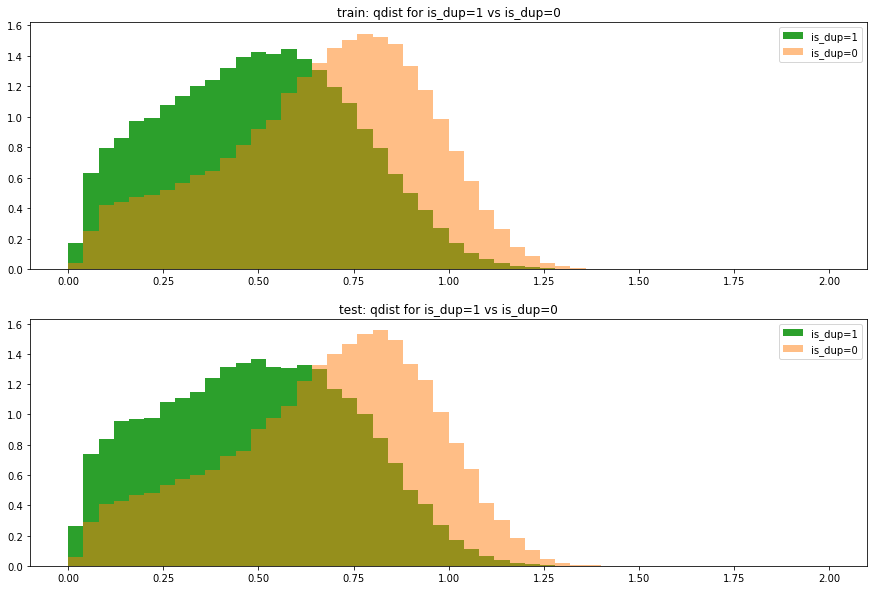

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
sel_dup = df_train.is_duplicate == 1
plt.hist(df_train.loc[sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[2], normed=True, label='is_dup=1')
plt.hist(df_train.loc[~sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[1], normed=True, alpha=0.5, label='is_dup=0')
plt.legend()
plt.title("train: qdist for is_dup=1 vs is_dup=0")
plt.subplot(2,1,2)
sel_dup = df_test.is_duplicate == 1
plt.hist(df_test.loc[sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[2], normed=True, label='is_dup=1')
plt.hist(df_test.loc[~sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[1], normed=True, alpha=0.5, label='is_dup=0')
plt.legend()
plt.title("test: qdist for is_dup=1 vs is_dup=0")


In [35]:
#sanity check: what are the pair of zero qdist like? 
sel = df_train['qdist'] == 0.
df_train[sel].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc,qdist


In [36]:
auc_train = roc_auc_score(1.0 - df_train['is_duplicate'], df_train['qdist'])
auc_test = roc_auc_score(1.0 - df_test['is_duplicate'], df_test['qdist'])
print("train_auc:%g, test_auc: %g" % (auc_train,auc_test))

train_auc:0.684567, test_auc: 0.689235
